## ANN
In this notebook we will implement a shallow ANN for classification from scratch. 

In [1]:
#Import libraries
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
import seaborn as sns

In [2]:
#Make a moons dataset
N = 10000
(X,y) = make_moons(n_samples=N, noise=0.2)

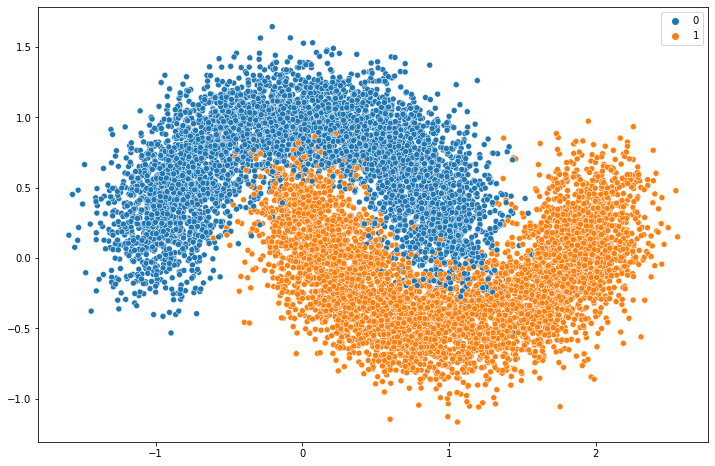

In [3]:
#Plot the data
plt.rcParams['figure.figsize'] = 12, 8
sns.scatterplot(x=X[:,0], y=X[:,1], hue=y)

In [4]:
#Lets do a train test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y)
y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)
print(f"X_train shape={X_train.shape}")
print(f"X_test shape={X_test.shape}")
print(f"y_train shape={y_train.shape}")
print(f"y_test shape={y_test.shape}")

X_train shape=(7500, 2)
X_test shape=(2500, 2)
y_train shape=(7500, 1)
y_test shape=(2500, 1)


In [5]:
#Lets apply logistic regression
from sklearn.linear_model import LogisticRegression

In [6]:
lr = LogisticRegression()
lr.fit(X_train, y_train)
print(f"Train score = {lr.score(X_train, y_train): 0.2}")
print(f"Test score = {lr.score(X_test, y_test):0.2}")

Train score =  0.87
Test score = 0.87


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [7]:
def plot_decision_boundary(model, X, y):
    # Set min and max values and give it some padding
    x_min, x_max = X[0, :].min() - 1, X[0, :].max() + 1
    y_min, y_max = X[1, :].min() - 1, X[1, :].max() + 1
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole grid
    Z = model(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.ylabel('x2')
    plt.xlabel('x1')
    plt.scatter(X[0, :], X[1, :], c=y, cmap=plt.cm.Spectral)
  

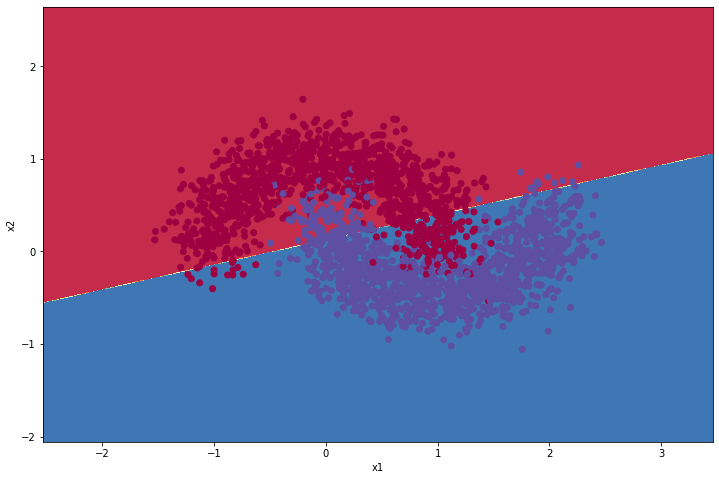

In [8]:
plot_decision_boundary(lambda x: lr.predict(x), X_test.T, y_test.T)

It not the greatest classifier we havent lerant the decision boundary

In [9]:
#Helper function to get layer sizes
def layer_sizes(X, Y, n_h):
    n_x = X.shape[0] 
    n_h = n_h
    n_y = Y.shape[0] 
    return (n_x, n_h, n_y)

In [10]:
#Sigmoid
def sigmoid(x):
    s = 1/(1+np.exp(-x))
    return s

In [11]:
#Now lets apply ANN from scratch
def initialize_parameters(n_x, n_h, n_y):
    #Lets imitialize parameters as normal random variables with small values
    #We want small values so as to avoid saturation of the neurons
    np.random.seed(2) 
    W1 = np.random.randn(n_h, n_x)*0.01
    b1 = np.zeros((n_h, 1))
    W2 = np.random.randn(n_y, n_h)*0.01
    b2 = np.zeros((n_y, 1)) 
    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2} 
    return parameters

In [12]:
#Implement foreward propogation
def forward_propagation(X, parameters):
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    Z1 = np.dot(W1, X) + b1
    A1 = np.tanh(Z1)
    Z2 = np.dot(W2, A1) + b2
    A2 = sigmoid(Z2)
    cache = {"Z1": Z1,
             "A1": A1,
             "Z2": Z2,
             "A2": A2}
    return A2, cache

In [13]:
#Compute cost
def compute_cost(A2, Y, parameters):
    m = Y.shape[1] 
    logprobs = np.multiply(np.log(A2),Y)+np.multiply(np.log(1-A2),(1-Y))
    cost = -np.sum(logprobs)/m
    cost = float(np.squeeze(cost))      
    return cost

In [14]:
#Lets implement backward propogation equations
def backward_propagation(parameters, cache, X, Y):
    m = X.shape[1]
    W1 = parameters["W1"]
    W2 = parameters["W2"]
    A1 = cache["A1"]
    A2 = cache["A2"]
    dZ2 = A2-Y
    dW2 = np.matmul(dZ2, A1.T)/m
    db2 = np.sum(dZ2, axis=1, keepdims=True)/m
    dZ1 = np.matmul(W2.T,dZ2)*(1-np.power(A1,2))
    dW1 = np.matmul(dZ1,X.T)/m
    db1 = np.sum(dZ1, axis=1, keepdims=True)/m
    grads = {"dW1": dW1,
             "db1": db1,
             "dW2": dW2,
             "db2": db2}
    return grads

In [15]:
#Apply gradient descent step
def update_parameters(parameters, grads, learning_rate = 1):
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    dW1 = grads["dW1"]
    db1 = grads["db1"]
    dW2 = grads["dW2"]
    db2 = grads["db2"]
    W1 = W1 - learning_rate * dW1
    b1 = b1 - learning_rate * db1
    W2 = W2 - learning_rate * dW2
    b2 = b2 - learning_rate * db2
    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}
    return parameters

In [16]:
#Put it all together in a model
def ANN(X, Y, n_h, num_iterations = 10000, print_cost=False):
    np.random.seed(3)
    n_x = layer_sizes(X, Y, n_h)[0]
    n_y = layer_sizes(X, Y, n_h)[2]
    parameters = initialize_parameters(n_x, n_h, n_y)
    for i in range(0, num_iterations):
        A2, cache = forward_propagation(X, parameters)
        cost = compute_cost(A2, Y, parameters)
        grads = backward_propagation(parameters, cache, X, Y)
        parameters = update_parameters(parameters, grads, learning_rate = 1.2)
        if print_cost and i % 1000 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
    return parameters

In [17]:
#Prediction function
def predict(parameters, X):
    A2, cache = forward_propagation(X, parameters)
    predictions = (A2 > 0.5)
    return predictions

In [18]:
#Train the model
parameters = ANN(X_train.T, y_train.T, n_h = 4, num_iterations = 10000, print_cost=True)

Cost after iteration 0: 0.692991
Cost after iteration 1000: 0.289819
Cost after iteration 2000: 0.082182
Cost after iteration 3000: 0.074843
Cost after iteration 4000: 0.073981
Cost after iteration 5000: 0.073456
Cost after iteration 6000: 0.073075
Cost after iteration 7000: 0.072779
Cost after iteration 8000: 0.072536
Cost after iteration 9000: 0.072324


Text(0.5, 1.0, 'Decision Boundary for hidden layer size 4')

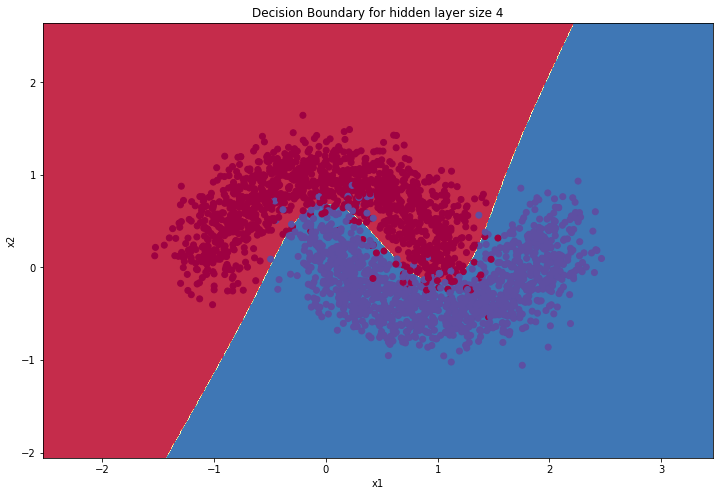

In [19]:
# Plot the decision boundary
plot_decision_boundary(lambda x: predict(parameters, x.T), X_test.T, y_test.T)
plt.title("Decision Boundary for hidden layer size " + str(4))

In [20]:
y_test_pred = predict(parameters, X_test.T)

In [21]:
y_test_pred = y_test_pred*1

In [22]:
from sklearn.metrics import accuracy_score
print(f"Accuracy Score={accuracy_score(y_test, y_test_pred.T):.2}")

Accuracy Score=0.97


We have a much better accuracy with an ANN in this case. ANN is able to learn the decision boundry very well.